In [31]:
from paddleocr import PaddleOCR
from pydantic import BaseModel
import cv2
import numpy as np


# # Initialize the OCR model; use GPU if available
# ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  # Use lang='ch' for Chinese, etc.

# # Specify the image path
# image_path = 'data/images/berserk.png'  # Replace with your image path

# # Perform OCR on the image
# result = ocr.ocr(image_path, cls=True)

# # Print the result
# for line in result:
#     for word_info in line:
#         print(f'Text: {word_info[1][0]}, Confidence: {word_info[1][1]}')

class OCR_Response(BaseModel):
    boxes: list
    texts: list




class OCR:
    def __init__(self):
        self.ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  
    

    def get_ocr(self, image_path: str):
        """
        Performs OCR on the given image.

        Args:
            image_path (str): The path to the image.

        Returns:
            OCR_Response: An OCR_Response object containing the bounding boxes and texts.
        """
        result = self.ocr.ocr(image_path, cls=True)
        boxes = []
        texts = []
        for line in result:
            for word_info in line:
                boxes.append(word_info[0])
                texts.append(word_info[1][0])
        return OCR_Response(boxes=boxes, texts=texts)
    

ocr = OCR()
response = ocr.get_ocr('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')

# Load the image
image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')

# Draw boxes around the text data
for text, box in zip(response.texts, response.boxes):
    print(f'Text: {text}, Box: {box}')
    box = [tuple(map(int, point)) for point in box]
    cv2.polylines(image, [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=2)
    # Write the image with boxes to a file

[2024/10/19 13:29:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/razor/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/razor/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

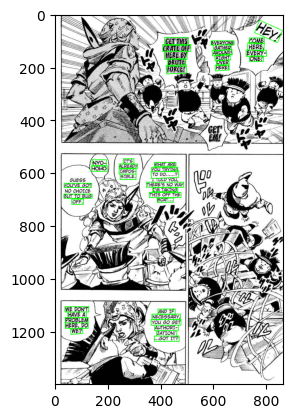

In [54]:
def intersecting_boxes(box1, box2):
    print("Merging boxes : ", box1, box2)
    """
    Checks if two boxes intersect.

    Args:
        box1 (list): The first box.
        box2 (list): The second box.

    Returns:
        bool: True if the boxes intersect, False otherwise.
    """


    acord1, acord2, acord3, acord4 = box1
    bcord1, bcord2, bcord3, bcord4 = box2

    box_1_y_average = (acord1[1] + acord2[1] + acord3[1] + acord4[1]) / 4
    box_2_y_average = (bcord1[1] + bcord2[1] + bcord3[1] + bcord4[1]) / 4

    box_1_x_average = (acord1[0] + acord2[0] + acord3[0] + acord4[0]) / 4
    box_2_x_average = (bcord1[0] + bcord2[0] + bcord3[0] + bcord4[0]) / 4



    if(abs(box_1_y_average - box_2_y_average) > 3 and abs(box_1_x_average - box_2_x_average) > 3):
        return False
    else:
        return True
    


def merge_boxes(box1, box2):
    """
    Merges two boxes.

    Args:
        box1 (list): The first box.
        box2 (list): The second box.

    Returns:
        list: The merged box.
    """

    acord1, acord2, acord3, acord4 = box1
    bcord1, bcord2, bcord3, bcord4 = box2

    x1 = min(acord1[0], acord2[0], acord3[0], acord4[0], bcord1[0], bcord2[0], bcord3[0], bcord4[0])
    x2 = max(acord1[0], acord2[0], acord3[0], acord4[0], bcord1[0], bcord2[0], bcord3[0], bcord4[0])
    y1 = min(acord1[1], acord2[1], acord3[1], acord4[1], bcord1[1], bcord2[1], bcord3[1], bcord4[1])
    y2 = max(acord1[1], acord2[1], acord3[1], acord4[1], bcord1[1], bcord2[1], bcord3[1], bcord4[1])

    return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

def merge_intersecting_boxes(boxes):
    """
    Merges intersecting boxes.

    Args:
        boxes (list): A list of boxes.

    Returns:
        list: A list of merged boxes.
    """
    merged_boxes = []
    for box in boxes:
        if not merged_boxes:
            merged_boxes.append(box)
        else:
            intersecting = False
            for i, merged_box in enumerate(merged_boxes):
                if intersecting_boxes(merged_box, box):
                    merged_boxes[i] = merge_boxes(merged_box, box)
                    intersecting = True
                    break
            if not intersecting:
                merged_boxes.append(box)
    return merged_boxes

merged_boxes = merge_intersecting_boxes(response.boxes)
print(merged_boxes)


Merging boxes :  [[773.0, 23.0], [860.0, 62.0], [841.0, 108.0], [754.0, 70.0]] [[414.0, 88.0], [504.0, 88.0], [504.0, 118.0], [414.0, 118.0]]
Merging boxes :  [[773.0, 23.0], [860.0, 62.0], [841.0, 108.0], [754.0, 70.0]] [[734.0, 90.0], [791.0, 90.0], [791.0, 112.0], [734.0, 112.0]]
Merging boxes :  [[414.0, 88.0], [504.0, 88.0], [504.0, 118.0], [414.0, 118.0]] [[734.0, 90.0], [791.0, 90.0], [791.0, 112.0], [734.0, 112.0]]
Merging boxes :  [[773.0, 23.0], [860.0, 62.0], [841.0, 108.0], [754.0, 70.0]] [[590.0, 101.0], [677.0, 101.0], [677.0, 117.0], [590.0, 117.0]]
Merging boxes :  [(414.0, 88.0), (791.0, 88.0), (791.0, 118.0), (414.0, 118.0)] [[590.0, 101.0], [677.0, 101.0], [677.0, 117.0], [590.0, 117.0]]
Merging boxes :  [[773.0, 23.0], [860.0, 62.0], [841.0, 108.0], [754.0, 70.0]] [[407.0, 115.0], [513.0, 115.0], [513.0, 141.0], [407.0, 141.0]]
Merging boxes :  [(414.0, 88.0), (791.0, 88.0), (791.0, 118.0), (414.0, 118.0)] [[407.0, 115.0], [513.0, 115.0], [513.0, 141.0], [407.0, 141

[[773.0, 23.0], [860.0, 62.0], [841.0, 108.0], [754.0, 70.0]]
[(414.0, 88.0), (791.0, 88.0), (791.0, 118.0), (414.0, 118.0)]
[(590.0, 101.0), (677.0, 101.0), (677.0, 215.0), (590.0, 215.0)]
[(407.0, 115.0), (513.0, 115.0), (513.0, 226.0), (407.0, 226.0)]
[(722.0, 107.0), (799.0, 107.0), (799.0, 179.0), (722.0, 179.0)]
[[413.0, 140.0], [499.0, 140.0], [499.0, 171.0], [413.0, 171.0]]
[(138.0, 551.0), (197.0, 551.0), (197.0, 595.0), (138.0, 595.0)]
[(242.0, 547.0), (312.0, 547.0), (312.0, 626.0), (242.0, 626.0)]
[(345.0, 561.0), (486.0, 561.0), (486.0, 712.0), (345.0, 712.0)]
[(33.0, 640.0), (140.0, 640.0), (140.0, 720.0), (33.0, 720.0)]
[(37.0, 1107.0), (127.0, 1107.0), (127.0, 1212.0), (37.0, 1212.0)]
[(363.0, 1116.0), (476.0, 1116.0), (476.0, 1238.0), (363.0, 1238.0)]


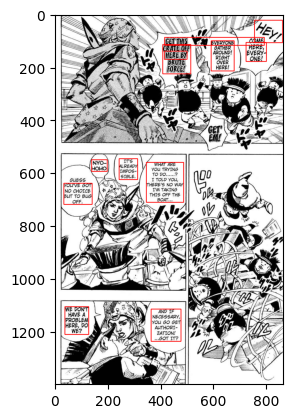

In [53]:
# Loop through each box and draw it on the image


image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')
for box in merged_boxes:
    a, b, c, d = box  # Unpacking the box coordinates
    ycoords = [a[1], b[1], c[1], d[1]]  # Y-coordinates of the box corners
    xcoords = [a[0], b[0], c[0], d[0]]  # X-coordinates of the box corners

    # Calculate the width and height of the bounding box
    width = max(xcoords) - min(xcoords)
    height = max(ycoords) - min(ycoords)

    # Skip boxes with zero width or height
    if width <= 0 or height <= 0:
        continue

    print(box)  # Optional: print the box coordinates for debugging
    # Draw the rectangle on the image
    cv2.rectangle(image, (int(min(xcoords)), int(min(ycoords))), 
                    (int(max(xcoords)), int(max(ycoords))), 
                    (255, 0, 0), 2)  # Green boxes with thickness 2

import matplotlib.pyplot as plt
plt.imshow(image)